Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). <br>Врамках проекта необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
<br>План работ:
<br>-изучение файла
<br>-заполнение пропусков
<br>-выявление актуального периода
<br>-исследовательский анализ актуального периода
<br>-проверка гипотез

### Шаг 1. Откроем файл.

In [1]:
import pandas as pd

In [2]:
data=pd.read_csv('/datasets/games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Вывод

В датасете 16715 записей.<br>
В столбцах year_of_release можно использовать целочисленный тип данных.<br>В столбце user_score - float.<br>Тип данных для critic_score мы определим в процессе работы.<br>
В столбцах name,year_of_release,genre,critic_score,user_score,rating есть пропущенные значения.
<br>Пропуски могут быть вызваны отсутствием данных на момент формирования датасета либо ошибкой.

### Шаг 2. Подготовка данных.

Приведем названия столбцов к нижнему регистру.

In [5]:
data.columns = [x.lower() for x in data.columns]

In [6]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

#### Заполним пропуски

В данных столбцах есть пропущенные значения.

In [7]:
data.columns[data.isnull().any()]

Index(['name', 'year_of_release', 'genre', 'critic_score', 'user_score',
       'rating'],
      dtype='object')

In [8]:
data.query('name.isnull()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Всего два пропуска в столбцах genre и name - заполним их маркером "unknown"

In [9]:
data['name'].fillna('unknown',inplace=True)

data['genre'].fillna('unknown',inplace=True)

Для заполнения пропусков в столбце year напишем функцию, которая будет по названию игры искать записанный в других строках год и возвращать его.<br>В случае если такого года нет - оставлять NaN.

In [10]:
def fill_year(data,name):
    return data.query('name==@name').sort_values(by='year_of_release')['year_of_release'].values[0]
    

Пример выполнения функции fill_year:

In [11]:
data.query('name=="Freaky Flyers"').sort_values(by='year_of_release')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
10551,Freaky Flyers,PS2,2003.0,Racing,0.05,0.04,0.0,0.01,66.0,tbd,T
14532,Freaky Flyers,XB,2003.0,Racing,0.02,0.01,0.0,0.00,64.0,tbd,T
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.0,0.00,69.0,6.5,T


In [12]:
data.loc[16405]

name               Freaky Flyers
platform                      GC
year_of_release              NaN
genre                     Racing
na_sales                    0.01
eu_sales                       0
jp_sales                       0
other_sales                    0
critic_score                  69
user_score                   6.5
rating                         T
Name: 16405, dtype: object

In [13]:
fill_year(data,'Freaky Flyers')

2003.0

In [14]:
data['year_of_release'].isnull().sum()

269

In [15]:
def year_from_name(row):
    name=row['name']
    year=row['year_of_release']
    if pd.isnull(year):
        return fill_year(data,name)
    return year

data['year_of_release']=data.apply(year_from_name,axis=1)
data['year_of_release'].isnull().sum()

146

Напишем аналогичную функцию для заполнения пропусков в столбце user_score на медианное значение строк этой же игры на других платформах, если такие строки существуют.

In [16]:
def fill_user_score(data,name):
     return data.query('name==@name and user_score!="tbd"')['user_score'].median()

In [17]:
def userscore_from_name(row):
    name=row['name']
    user_score=row['user_score']
    if pd.isnull(user_score):
        return fill_user_score(data,name)
    return user_score

In [18]:
data['user_score'].isnull().sum()

6701

In [19]:
data['user_score']=data.apply(userscore_from_name,axis=1)


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [20]:
data['user_score'].isnull().sum()

6350

Напишем аналогичную функцию для заполнения пропусков в столбце critic_score на медианное значение строк этой же игры на других платформах, если такие строки существуют.

In [21]:
def fill_critic_score(data,name):
     return data.query('name==@name')['critic_score'].median().round()

In [22]:
def criticscore_from_name(row):
    name=row['name']
    critic_score=row['critic_score']
    if pd.isnull(critic_score):
        return fill_critic_score(data,name)
    return critic_score

In [23]:
data['critic_score'].isnull().sum()

8578

In [24]:
data['critic_score']=data.apply(criticscore_from_name,axis=1)

In [25]:
data['critic_score'].isnull().sum()

7617

Напишем аналогичную функцию для заполнения пропусков в столбце rating на наиболее новое значение рейтинга этой же игры на других платформах, если такие строки существуют.

In [26]:
def fill_rating(data,name):
    return data.query('name==@name')['rating'].sort_values().values[0]

In [27]:
def rating_from_name(row):
    name=row['name']
    rating=row['rating']
    if pd.isnull(rating):
        return fill_rating(data,name)
    return rating

In [28]:
data['rating'].isnull().sum()

6766

In [29]:
data['rating']=data.apply(rating_from_name,axis=1)

In [30]:
data['rating'].isnull().sum()

6329

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16715 non-null object
platform           16715 non-null object
year_of_release    16569 non-null float64
genre              16715 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       9098 non-null float64
user_score         10365 non-null object
rating             10386 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


У нас остались пропуски, но мы решаем не заполнять их расчетными значениями, чтобы не исказить существующие взаимосвязи.

In [32]:
data.query('year_of_release.isnull()').head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.0,0.41,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.0,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
805,Rock Band,Wii,NaN,Misc,1.33,0.56,0.0,0.20,80.0,6.3,T
1142,Rock Band,PS3,NaN,Misc,0.99,0.41,0.0,0.22,92.0,8.4,T


Причины, возникновения пропусков могут быть следующими:<br>
-для столбца year_of_release скорее всего это небольшой сбор при формировании датасета<br>
-для столбцов  	critic_score,user_score,rating данных могло не быть на момент формирования датасета - обычно для расчета critic_score и user_score требуется определенное минимальное количество отзывов - их может быть недостаточно даже на сегодняшний момент, также для столбца rating может в принципе отсутствовать оценка от ESRB - есть и другие агенства.<br>
Необходимо запросить осуществлять актуализацию данных, это поможет сократить число пропущенных значений.

#### Посмотрим на значения "tbd" в столбце user_score

In [33]:
data.query('user_score=="tbd"').describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,2394.000000,2424.000000,2424.000000,2424.000000,2424.000000,1360.000000
mean,2007.440685,0.126052,0.043519,0.002727,0.015862,60.372794
std,3.490066,0.180586,0.111412,0.026136,0.039156,11.993682
min,1997.000000,0.000000,0.000000,0.000000,0.000000,19.000000
25%,2005.000000,0.030000,0.000000,0.000000,0.000000,53.000000
50%,2008.000000,0.075000,0.010000,0.000000,0.010000,61.000000
75%,2010.000000,0.150000,0.040000,0.000000,0.020000,69.000000
max,2016.000000,3.450000,2.590000,0.860000,1.090000,90.000000


In [34]:
data.query('user_score!="tbd"').describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,14175.000000,14291.000000,14291.000000,14291.000000,14291.000000,7738.000000
mean,2006.325855,0.286670,0.162283,0.090320,0.052681,70.262988
std,6.163727,0.874623,0.540532,0.332179,0.200815,13.952077
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,62.000000
50%,2007.000000,0.080000,0.030000,0.000000,0.010000,72.000000
75%,2011.000000,0.260000,0.130000,0.050000,0.040000,81.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [35]:
data.query('user_score!="tbd"').describe(include=['O'])

,name,platform,genre,user_score,rating
count,14291,14291,14291,7941,8004
unique,10201,31,13,192,8
top,Need for Speed: Most Wanted,PS2,Action,7.8,T
freq,12,1921,2993,324,2703


In [36]:
data.query('user_score=="tbd"')['rating'].value_counts(normalize=True)#.describe(include=['O'])

E       0.663728
T       0.159950
E10+    0.155751
M       0.017632
EC      0.002939
Name: rating, dtype: float64

In [37]:
data.query('user_score!="tbd"')['rating'].value_counts(normalize=True)

T       0.337706
E       0.322339
M       0.201399
E10+    0.137181
K-A     0.000500
RP      0.000375
EC      0.000375
AO      0.000125
Name: rating, dtype: float64

Виден перекос в сторону рейтинга "E"(everyone) у значений с user_score=="tbd", возможно для рейтинга E требуется больше оценок для присвоения user_score и этим объясняется такой перекос.<br>
Заменим значения "tbd" на NaN для удобства работы с числовыми значениями.<br>
Также передадим просьбу об актуализации датасета - возможно некоторым играм уже присвоили значение user_score.

In [38]:
data['user_score']=data['user_score'].astype(str).apply(lambda x: x.replace('tbd','nan'))
data['user_score'].value_counts()

nan                   8774
7.8                    337
8.2                    294
8                      290
8.3                    270
                      ... 
7.25                     1
7.300000000000001        1
7.8500000000000005       1
8.85                     1
4.800000000000001        1
Name: user_score, Length: 140, dtype: int64

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16715 non-null object
platform           16715 non-null object
year_of_release    16569 non-null float64
genre              16715 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       9098 non-null float64
user_score         16715 non-null object
rating             10386 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


##### Заменим тип данных

Заменим типы данных столбцов year_of_release и cricit_score с float на целочисленный.<br>Т.к. в столбцах присутствуют пропуски - целочисленный тип выберем Int64.<br>
В столбце user_score и critic_score изменим тип данных на float64.
<br>Столбец critic_score мы решаем заменить на float64, т.к. Int64(целочисленный с nan) не дает производить некоторые операции.

In [40]:
data['year_of_release']=data['year_of_release'].astype('Int64')

data['critic_score']=data['critic_score'].astype('float64')

data['user_score']=data['user_score'].astype('float64')

##### Добавим столбец общих продаж

In [41]:
data['total_sales']=data['na_sales']+data['eu_sales']+data['jp_sales']+data['other_sales']

In [42]:
data.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24


In [43]:
data.query('platform=="XOne"')['total_sales'].sum()

159.32

In [44]:
data.query('platform=="PS3" and year_of_release==1991')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
4127,Sonic the Hedgehog,PS3,1991,Platform,0.0,0.48,0.0,0.0,43.0,4.1,E10+,0.48


### Вывод

В данном разделе мы привели названия столбцов к нижнему регистру, заполнили пропуски, насколько это было возможным, заменили значение tbd на пустые значения, добавили столбец с общими продажами и заменили типы данных.

### Шаг 3. Исследовательский анализ данных

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats

#### Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

Сгруппируем данные об играх по году и возьмем кумулятивную сумму выпуска игр в каждом году.<br>Вычислим квантили полученного ряда.

In [46]:
games_cumsum=data.groupby('year_of_release')['name'].count().cumsum()
quantiles = mstats.mquantiles(games_cumsum, axis=0)

Мы решаем разделить значения по медиане.

In [47]:
quantiles[1]

1641.0

Найдем год, соответствующий медианному значению.

In [48]:
games_cumsum[games_cumsum==quantiles[1]].index[0]

1998

Построим линейный график по полученным значениям.

Text(0, 0.5, 'cumulative count')

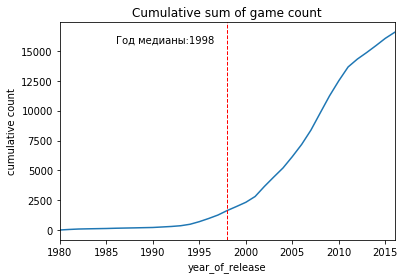

In [49]:
games_cumsum.plot(kind='line')
plt.axvline(games_cumsum[games_cumsum==quantiles[1]].index[0], color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(games_cumsum[games_cumsum==quantiles[1]].index[0]-12, max_ylim*0.9,'Год медианы:{}'.format(games_cumsum[games_cumsum==quantiles[1]].index[0]))
plt.title('Cumulative sum of game count')
plt.ylabel('cumulative count')

#### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Выберем топ-10 платформ по продажам и построим для них распределения по годам.

In [50]:
top10sales=data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10)

In [51]:
sales_by_platform=data.query('platform.isin(@top10sales.index)').pivot_table(index=['platform','year_of_release'],values='total_sales',aggfunc='sum').reset_index()

Text(0.5, 0.98, 'Lineplots of top10 platforms by total sales')

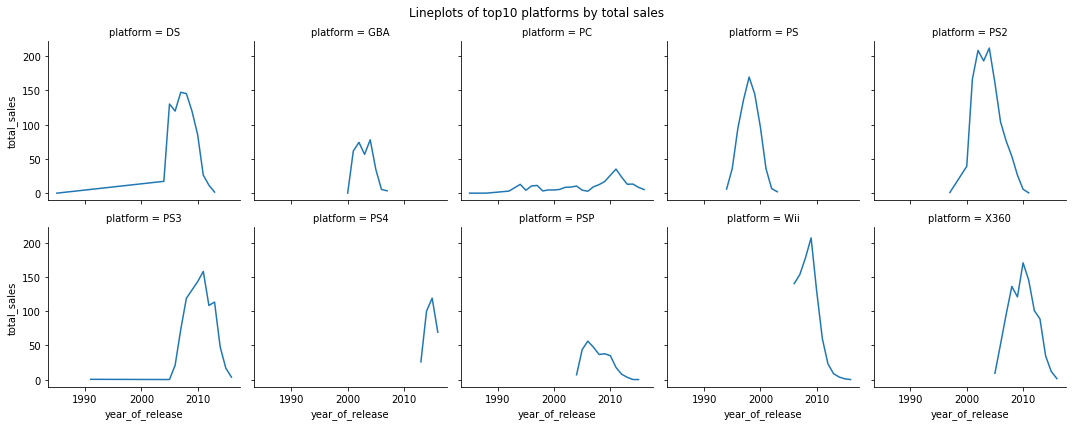

In [53]:
g=sns.FacetGrid(sales_by_platform,col='platform',col_wrap=5)
g.map(sns.lineplot,'year_of_release','total_sales')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Lineplots of top10 platforms by total sales')

Для большинства платформ характерен резкий рост и такое же резкое падение, за исключением одной - PC.<br>Среднее время жизни платформы на глаз составляет примерно 10 лет. Проверим точнее.

Также мы видим единичные записи для платформ PS3 и DS датируемые в ранних 1990-х годах. Вероятно, это ошибки. Ограничим период при расчете времени жизни 1998 годом.

In [54]:
max_year=sales_by_platform.query('year_of_release>=1998').groupby('platform')['year_of_release'].max()

In [55]:
min_year=sales_by_platform.query('year_of_release>=1998').groupby('platform')['year_of_release'].min()

In [56]:
time_life=max_year-min_year

In [57]:
time_life.mean()

9.6

Среднее время жизни платформы - 9.6 лет.

Актуальный период определим как 1998 год + одно поколение платформ = 2007 год.

In [58]:
actual_data=data.query('year_of_release>=2007')

Также уберем данные по этим платформам, так как их слишком мало для любых выводов.

In [59]:
notinplatforms=actual_data['platform'].value_counts().tail(4).index
                                                        
actual_data['platform'].value_counts().tail(4)

GBA    6
XB     4
GC     4
DC     2
Name: platform, dtype: int64

In [60]:
notinplatforms

Index(['GBA', 'XB', 'GC', 'DC'], dtype='object')

In [61]:
actual_data=actual_data.query('~platform.isin(@notinplatforms)')

#### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.


In [62]:
platforms=actual_data.pivot_table(index=['platform','year_of_release'],values='total_sales',aggfunc='sum').reset_index()

In [64]:
platforms.fillna(0,inplace=True)

Text(0.5, 0.98, 'Lineplots of sales by platform')

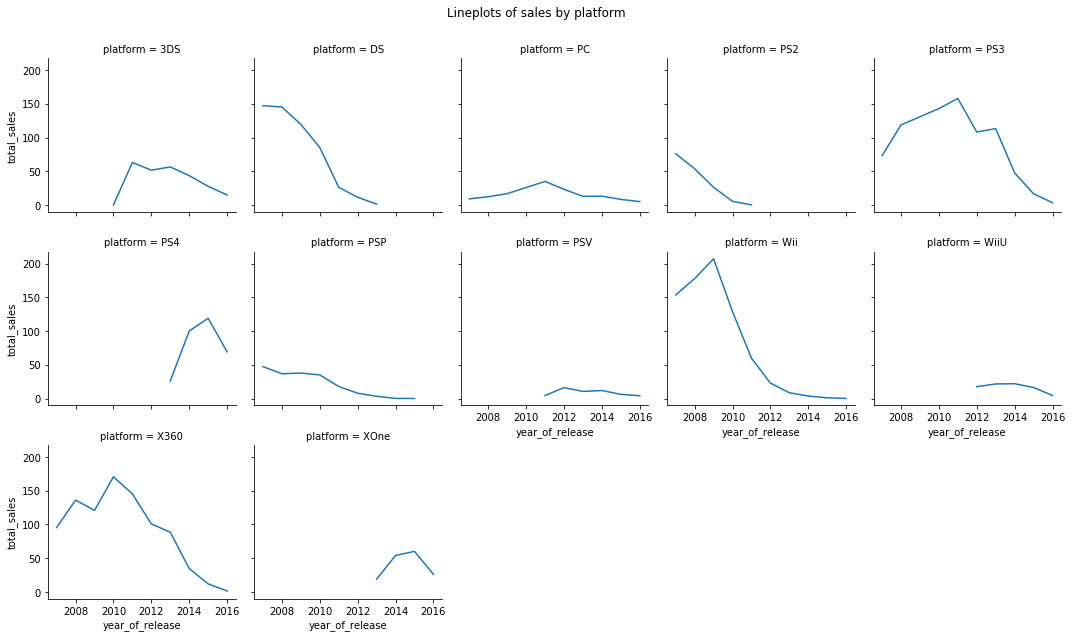

In [65]:
g=sns.FacetGrid(platforms,col='platform',col_wrap=5)
g.map(sns.lineplot,'year_of_release','total_sales')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Lineplots of sales by platform')

Мы можем выделить лишь три платформы: PS4,XOne и PC.<br>Во всех остальных заметен сильный спад.<br>Продажи ир на PC также не высоки, однако они такими и были и показывают стабильные продажи.

##### Соотнесите выводы с продажами игр на других платформах.

In [66]:
best3=['PS4','XOne','PC']
actual_data.query('platform.isin(@best3)')['total_sales'].describe()

count    1374.000000
mean        0.463661
std         1.080127
min         0.010000
25%         0.030000
50%         0.090000
75%         0.380000
max        14.630000
Name: total_sales, dtype: float64

In [67]:
actual_data.query('~platform.isin(@best3)')['total_sales'].describe()

count    8004.000000
mean        0.482597
std         1.325462
min         0.000000
25%         0.050000
50%         0.150000
75%         0.420000
max        35.520000
Name: total_sales, dtype: float64

Среднее однако по остальным платформам выше, как и медиана, но это вызвано лишь большими предыдущими продажами, на графиках заметен явный спад, длящийся не один год.

Ограничим период 2014 годом, чтобы проверить это.

In [68]:
actual_data.query('platform.isin(@best3) and year_of_release>=2014')['total_sales'].describe()

count    755.000000
mean       0.603391
std        1.302988
min        0.010000
25%        0.040000
50%        0.150000
75%        0.535000
max       14.630000
Name: total_sales, dtype: float64

In [69]:
actual_data.query('~platform.isin(@best3) and year_of_release>=2014')['total_sales'].describe()

count    934.000000
mean       0.293244
std        0.776431
min        0.010000
25%        0.030000
50%        0.070000
75%        0.230000
max       11.680000
Name: total_sales, dtype: float64

#### Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.


Построим боксплот по продажам с разбивкой по платформам.

Text(0.5, 1.0, 'Boxplots of platforms by total_sales')

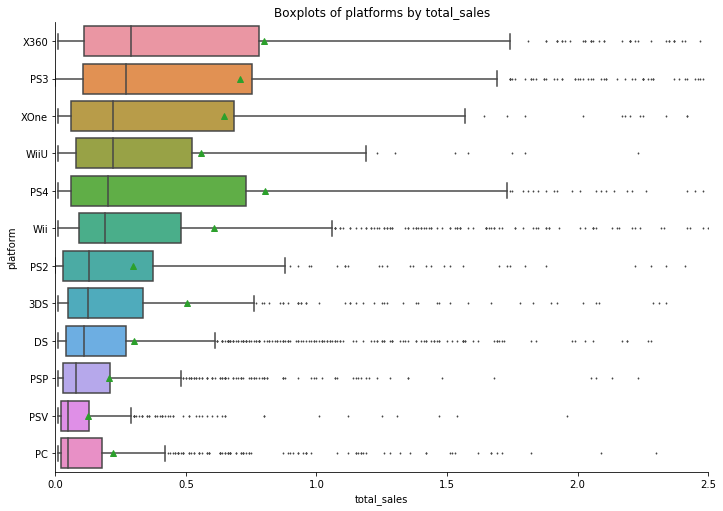

In [191]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax.set_xlim(0, 2.5)
sns.boxplot(data=actual_data,x='total_sales',y='platform',fliersize=1,showmeans=True,ax=ax,order=actual_data.groupby('platform')['total_sales'].median().sort_values(ascending=False).index)
sns.despine()
plt.title('Boxplots of platforms by total_sales', fontsize=12)


Наиболее выгодные платформы - X360, PS3, XOne.

Разница между первыми пятью и остальными довольно большая.<br>Средние значения также убывают к низу списка.

#### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.


In [71]:
actual_data['total_sales'].corr(actual_data['user_score'])

0.09276687417791141

Text(0.5, 0.98, 'Scatterplot of sales by user_score')

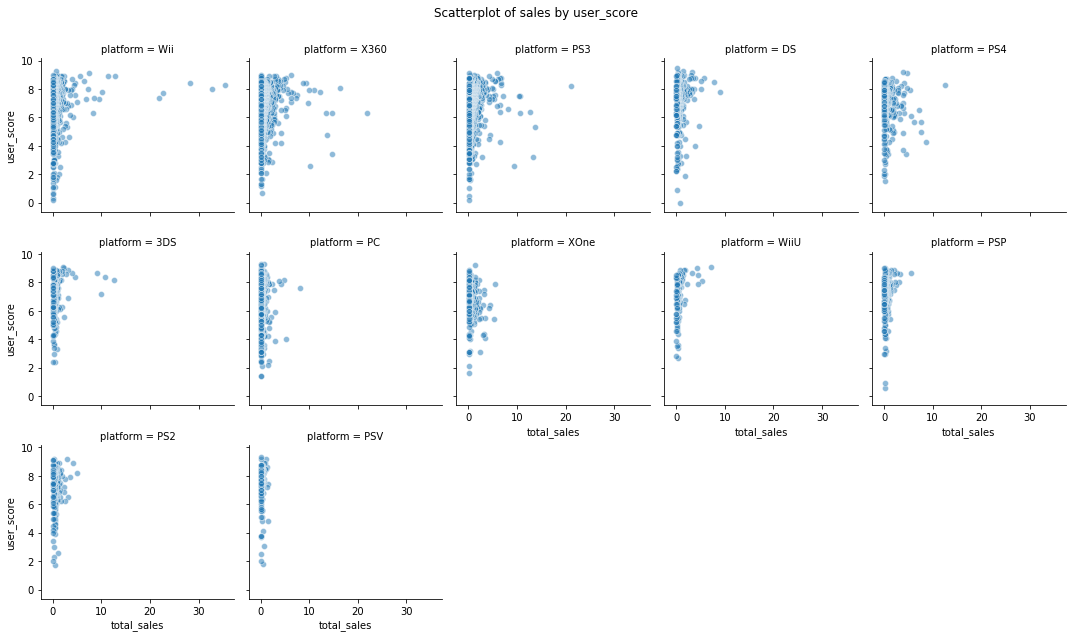

In [72]:
g=sns.FacetGrid(actual_data,col='platform',col_wrap=5)
g.map(sns.scatterplot,'total_sales','user_score',alpha=0.5)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Scatterplot of sales by user_score')

In [73]:
actual_data['total_sales'].corr(actual_data['critic_score'])

0.277421766800523

Text(0.5, 0.98, 'Scatterplot of sales by critic_score')

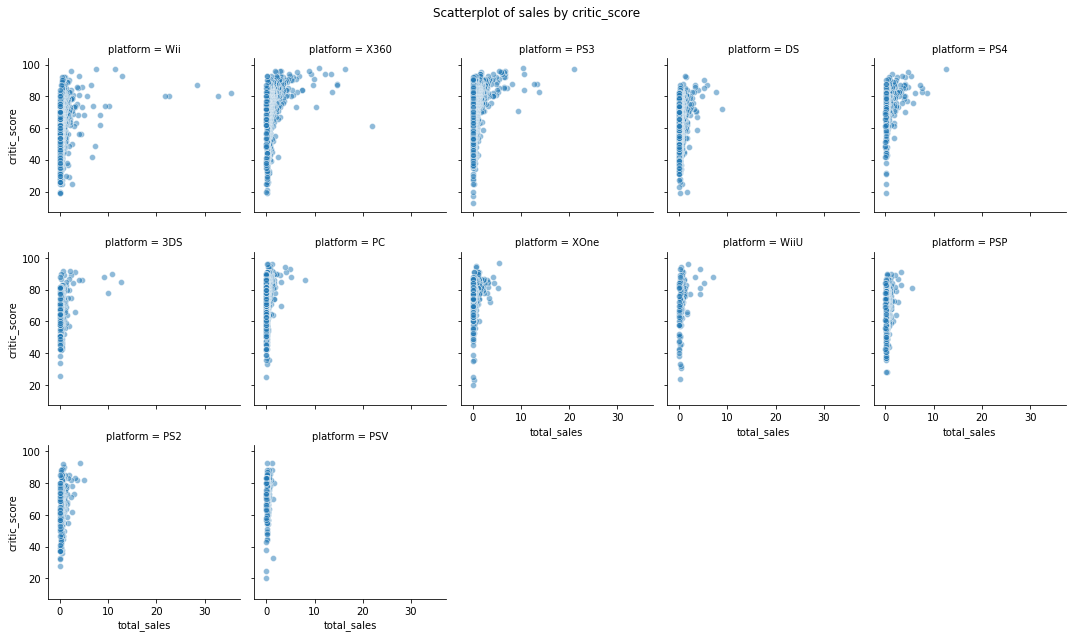

In [74]:
g=sns.FacetGrid(actual_data,col='platform',col_wrap=5)
g.map(sns.scatterplot,'total_sales','critic_score',alpha=0.5)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Scatterplot of sales by critic_score')

Мы видим слабую корреляцию с продажами для user_score и около-среднюю для critic_score - графики подтверждают это.

#### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Построим гистограмму жанров.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

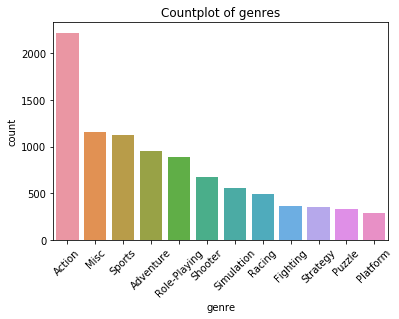

In [84]:
sns.countplot(x='genre',data=actual_data,order=actual_data['genre'].value_counts().index)
plt.title('Countplot of genres', fontsize=12)
plt.xticks(rotation=45)

Видно доминирование жанра Action.

Построим скрипичный график по жанрам для определения наиболее прибыльного жанра.<br>
Для этого сгруппируем данные по жанру и году(для укрупнения чисел и более наглядного представления) и просуммируем total_sales.

In [77]:
sales_by_genre=actual_data.pivot_table(index=['genre','year_of_release'],values='total_sales',aggfunc='sum').reset_index()

In [78]:
sales_by_genre.sort_values(by='total_sales',ascending=False,inplace=True)

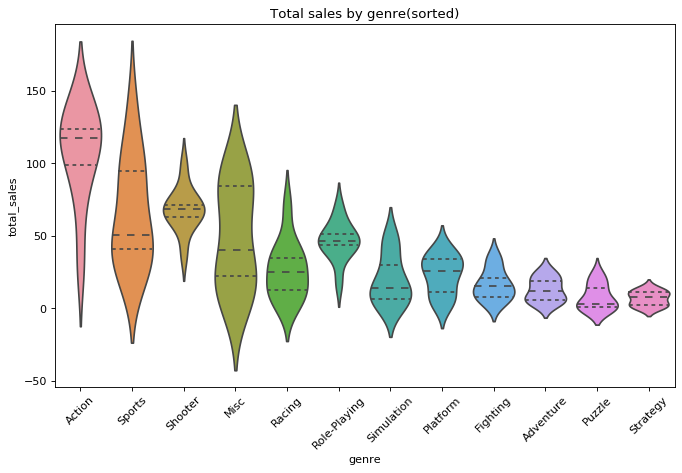

In [79]:
plt.figure(figsize=(10,6), dpi= 80)
sns.violinplot(x=sales_by_genre.genre, y=sales_by_genre.total_sales, data=sales_by_genre, scale='count', inner='quartile')


plt.title('Total sales by genre(sorted)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Выделим топ-3 жанров и построим гистограмы по рейтингу и платформам.

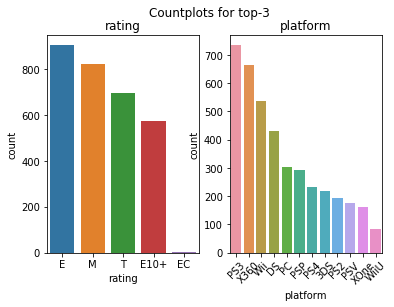

In [197]:
top_sales=['Action','Sports','Shooter']

categorical_features = ["rating", "platform"]
fig, ax = plt.subplots(1, len(categorical_features))
fig.suptitle('Countplots for top-3')
top3=actual_data.query('genre.isin(@top_sales)')
not_top=actual_data.query('~genre.isin(@top_sales)')
for i, categorical_feature in enumerate(top3[categorical_features]):
    sns.countplot(x=top3[categorical_feature], data=top3,ax=ax[i],order = top3[categorical_feature].value_counts().index).set_title(categorical_feature)
    plt.xticks(rotation=45)

fig.show()

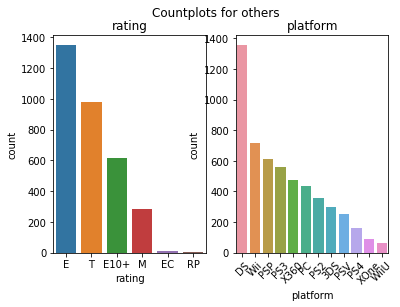

In [198]:
fig, ax = plt.subplots(1, len(categorical_features))
fig.suptitle('Countplots for others')
for i, categorical_feature in enumerate(not_top[categorical_features]):
    sns.countplot(x=not_top[categorical_feature], data=not_top,ax=ax[i],order = not_top[categorical_feature].value_counts().index).set_title(categorical_feature)
    plt.xticks(rotation=45)
fig.show()

Заметно преобладание в обеих выборках рейтинга E - Everyone.<br>
Самые прибыльные жанры же выпускают на платформах Ps3 и X360.

### Вывод

В данном разделе мы выделили актуальный период, выделили наиболее прибыльные платформы, выяснили как влияют отзывы на продажи, выделили самые прибыльные жанры и рассмотрели как они отличаются от не самых прибыльных.

### Шаг 4. Составьте портрет пользователя каждого региона

Определите для пользователя каждого региона (NA, EU, JP):

    Самые популярные платформы (топ-5). Опишите различия в долях продаж.
    Самые популярные жанры (топ-5). Поясните разницу.
    Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [113]:
na_platforms=actual_data.pivot_table(index='platform',values=['na_sales'],aggfunc='sum').reset_index().sort_values(ascending=False,by='na_sales')[:5]

eu_platforms=actual_data.pivot_table(index='platform',values=['eu_sales'],aggfunc='sum').reset_index().sort_values(ascending=False,by='eu_sales')[:5]

jp_platforms=actual_data.pivot_table(index='platform',values=['jp_sales'],aggfunc='sum').reset_index().sort_values(ascending=False,by='jp_sales')[:5]

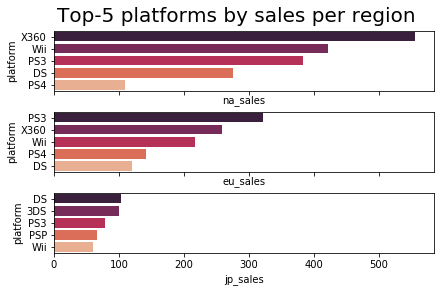

In [147]:
fig, axes = plt.subplots(nrows=3, sharey=False,sharex=True)
fig.suptitle('Top-5 platforms by sales per region', size=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
sns.barplot(y='platform',x='na_sales', data=na_platforms, palette='rocket',ax=axes[0])
sns.barplot(y='platform',x='eu_sales', data=eu_platforms, palette='rocket',ax=axes[1])
sns.barplot(y='platform',x='jp_sales', data=jp_platforms, palette='rocket',ax=axes[2])



В Северной Америке популярна X360, в Европе - PS3, а в Японии - Nintendo DS.

In [144]:
na_genres=actual_data.pivot_table(index='genre',values=['na_sales'],aggfunc='sum').reset_index().sort_values(ascending=False,by='na_sales')[:5]

eu_genres=actual_data.pivot_table(index='genre',values=['eu_sales'],aggfunc='sum').reset_index().sort_values(ascending=False,by='eu_sales')[:5]

jp_genres=actual_data.pivot_table(index='genre',values=['jp_sales'],aggfunc='sum').reset_index().sort_values(ascending=False,by='jp_sales')[:5]

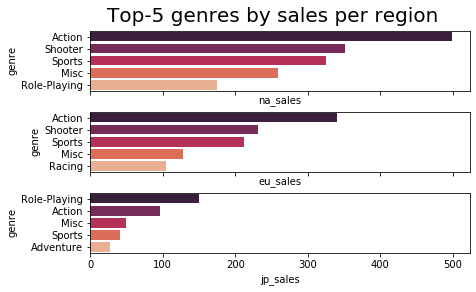

In [148]:
fig, axes = plt.subplots(nrows=3, sharey=False,sharex=True)
fig.suptitle('Top-5 genres by sales per region', size=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
sns.barplot(y='genre',x='na_sales', data=na_genres, palette='rocket',ax=axes[0])
sns.barplot(y='genre',x='eu_sales', data=eu_genres, palette='rocket',ax=axes[1])
sns.barplot(y='genre',x='jp_sales', data=jp_genres, palette='rocket',ax=axes[2])

В Америке и Европе наибольшей популярностью пользуются игры жанра Action,в Японии же они на втором месте - а на первом Role-playing.

In [149]:
actual_data['rating'].value_counts()

E       2248
T       1669
E10+    1189
M       1105
EC         8
RP         1
Name: rating, dtype: int64

Рейтинги EC и RP имеют всего 8 и 1 запись - уберем их из рассмотрения для улучшения наглядности графиков.

In [150]:
na_rating=actual_data.pivot_table(index='rating',values=['na_sales'],aggfunc='sum').reset_index().sort_values(ascending=False,by='na_sales')[:4]

eu_rating=actual_data.pivot_table(index='rating',values=['eu_sales'],aggfunc='sum').reset_index().sort_values(ascending=False,by='eu_sales')[:4]

jp_rating=actual_data.pivot_table(index='rating',values=['jp_sales'],aggfunc='sum').reset_index().sort_values(ascending=False,by='jp_sales')[:4]

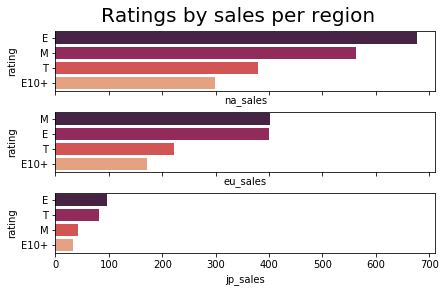

In [151]:
fig, axes = plt.subplots(nrows=3, sharey=False,sharex=True)
fig.suptitle('Ratings by sales per region', size=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
sns.barplot(y='rating',x='na_sales', data=na_rating, palette='rocket',ax=axes[0])
sns.barplot(y='rating',x='eu_sales', data=eu_rating, palette='rocket',ax=axes[1])
sns.barplot(y='rating',x='jp_sales', data=jp_rating, palette='rocket',ax=axes[2])

Везде распределение рейтингов очень похоже - наибольшей популярностью пользуются игры для всех или только для взрослых.

#### Вывод

В данном разделе мы выделили наиболее прибыльные платформы и жанры в каждом из регионов, а также рассмотрели влияет ли рейтинг на продажи.

### Шаг 5. Проверьте гипотезы

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;


Проверим гипотезу о том, что пользовательские рейтинги платформ Xbox One и PC одинаковые
.<br>Сформулируем нулевую и альтернативную гипотезы:<br>
H0: средние пользовательские рейтинги платформ Xbox One и PC не различаются<br>
H1: средние пользовательские рейтинги платформ Xbox One и PC не различаются различаются

In [166]:
from scipy import stats as st

In [158]:
pc_data=actual_data.query('platform=="PC"').dropna()['user_score']
xbox_data=actual_data.query('platform=="XOne"').dropna()['user_score']
alpha = .05
results = st.ttest_ind(pc_data,xbox_data,equal_var=False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.26084598373552126
Не получилось отвергнуть нулевую гипотезу


Гипотезу о разнице в средних отвергнуть не удалось, посмотрим на средние значения и построим доверительные интервал на уровне значимости 0.05.

In [162]:
print('Средний пользовательский рейтинг для PC:',pc_data.mean())
print('Средний пользовательский рейтинг для XBOX ONE:',xbox_data.mean())

Средний пользовательский рейтинг для PC: 6.731155303030302
Средний пользовательский рейтинг для XBOX ONE: 6.597179487179488


In [167]:
st.t.interval(0.95, len(pc_data)-1, loc=pc_data.mean(), scale=st.sem(pc_data))

(6.599103127535926, 6.863207478524679)

In [168]:
st.t.interval(0.95, len(xbox_data)-1, loc=xbox_data.mean(), scale=st.sem(xbox_data))

(6.403559317604609, 6.790799656754368)

Проверим гипотезу о том, что пользовательские рейтинги игр жанра Action и Sports одинаковые
.<br>Сформулируем нулевую и альтернативную гипотезы:<br>
H0: средние пользовательские рейтинги платформ Action и Sports не различаются<br>
H1: средние пользовательские рейтинги платформ Action и Sports не различаются

In [159]:
action_data=actual_data.query('genre=="Action"').dropna()['user_score']
sports_data=actual_data.query('genre=="Sports"').dropna()['user_score']
alpha = .05
results = st.ttest_ind(action_data,sports_data,equal_var=False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.9037014923030233e-12
Отвергаем нулевую гипотезу


Средние пользовательские рейтинги жанров Action и Sports разные.

In [163]:
print('Средний пользовательский рейтинг для Action-игр:',action_data.mean())
print('Средний пользовательский рейтинг для Sports-игр:',sports_data.mean())

Средний пользовательский рейтинг для Action-игр: 6.869032513877873
Средний пользовательский рейтинг для Sports-игр: 6.317508710801394


In [170]:
st.t.interval(0.95, len(action_data)-1, loc=action_data.mean(), scale=st.sem(action_data))

(6.795095353688453, 6.942969674067294)

In [169]:
st.t.interval(0.95, len(sports_data)-1, loc=sports_data.mean(), scale=st.sem(sports_data))

(6.183508539274776, 6.451508882328012)

#### Вывод

В данном разделе мы проверили две гипотезы о равенстве средних.

### Общий вывод

В ходе проекта были заполнены пропуски в данных, заменены типы данных.<br>
Был добавлен столбец с общими продажами.<br>
Был выявлен актуальный период - с 2007 года.<br>
Были выявлены три лидирующие платформы - PS4,XOne и PC.<br>
Были выявлены наиболее выгодные платформы - X360, PS3, XOne.<br>
Была посчитан корреляция с продажами для user_score и critic_score.<br>
Было замечено доминирование игр жанра Action.<br>
Заметно преобладание рейтинга E - Everyone.<br>
Самые прибыльные жанры выпускают на платформах Ps3 и X360.<br>
Были сделаны следующие выводы по регионам:
<br>В Северной Америке популярна X360, в Европе - PS3, а в Японии - Nintendo DS.
<br>В Америке и Европе наибольшей популярностью пользуются игры жанра Action,в Японии же они на втором месте - а на первом Role-playing.
<br>Везде распределение рейтингов очень похоже - наибольшей популярностью пользуются игры для всех или только для взрослых.
<br>Были проверены гипотезы о равенстве средних и построены доверительные интервалы для пользовательского рейтинга.
